# HOW TO obtain catalogue data collected with ESO-VISTA 

Catalogues produced by PIs of ESO observing programmes are integrated into the ESO science archive through the [Phase 3 process](https://www.eso.org/sci/observing/phase3.html) and are accessible either via the [ESO Archive Science Portal](https://archive.eso.org/scienceportal/home?dp_type=CATALOG&sort=-obs_date), or via the [Catalog Facility](https://www.eso.org/qi/), or [programmatically](http://archive.eso.org/programmatic/#TAP?e=1) via the `tap_cat` service.

In the following, we will show how to collect catalogue entries associated with the [ESO-VISTA telescope](https://www.eso.org/sci/facilities/paranal/telescopes/vista.html). This will be done by exploiting the `archive_catalogues` module part of the [ESOAsg](https://esoasg.readthedocs.io/en/latest/) `python` repository. This is a wrapper around the [_programmatic access_](http://archive.eso.org/programmatic/#TAP) that allows users to embed [Virtual Observatory Table Access Protocol (TAP)](https://www.ivoa.net/documents/TAP/20190927/) queries within their `python` environment. 

In [1]:
%matplotlib notebook

In [2]:
from ESOAsg.ancillary import astro
from ESOAsg import archive_catalogues
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

## Obtain information on all catalogues present in the ESO Archive

The full list of available scientific catalogues could be found [here](https://www.eso.org/qi/). Alternatively, this information can retrived by using:
```python
archive_catalogues.all_catalogues_info(all_versions=True)
```
This will return an astropy table of all catalogues (and all their versions). Note that the column `last_version` highlights with `False` and obsolete catalogues for which a newer version is present. 

It is however possible to remove these obsolete versions by setting:
```python
all_version=False # i.e. the default behavior
```

In [3]:
all_catalogues = archive_catalogues.catalogues_info(all_versions=False)

Now `all_catalogues` contains information on all the latest versions of the catalogues currently present at ESO:

In [4]:
all_catalogues['collection', 'table_name', 'title', 'version', 'instrument', 'telescope'][0:5].show_in_notebook(show_row_index=False, display_length=5)

collection,table_name,title,version,instrument,telescope
196.D-0214,EREBOS_RV_cat_fits_V1,EREBOS_RV_cat.fits,1,FORS2,ESO-VLT-U1
196.D-0214,EREBOS_cat_fits_V1,EREBOS_cat.fits,1,FORS2,ESO-VLT-U1
AMBRE,AMBRE_V1,Atmospheric Parameters and Chemical Abundances from Stellar Spectra,1,FEROS,MPI-2.2
ATLASGAL,ATLASGAL_V1,ATLASGAL - APEX Large Area Survey of the Galaxy,1,APEXBOL,APEX-12m
FDS,FDS_SourceCatalogue_V1,Fornax Deep Survey Source Catalogue,1,OMEGACAM,ESO-VST


## Get the catalogues

Given that `all_catalogues` is a `Table` you can create a filter based on the `telescope` column. Possible values are:

In [5]:
print('Possible values for the telescope entry: \n {}'.format(np.unique(all_catalogues['telescope']).tolist()))

Possible values for the telescope entry: 
 ['', 'APEX-12m', 'ESO-NTT', 'ESO-VISTA', 'ESO-VLT-U1', 'ESO-VLT-U2', 'ESO-VLT-U2,ESO-VLT-U3', 'ESO-VLT-U3', 'ESO-VLT-U4', 'ESO-VST', 'ESO-VST, ESO-VISTA', 'MPI-2.2', 'NGTS', 'UT1', 'UT3']


You can now select all the `ESO-VISTA` catalogues applying a filter for 'ESO-VISTA' and 'ESO-VST, ESO-VISTA' to the `all_catalogues` table:

In [6]:
vista_telescope_filter = (all_catalogues['telescope'] == 'ESO-VISTA') | (all_catalogues['telescope'] == 'ESO-VST, ESO-VISTA')
vista_catalogues = all_catalogues.copy()[vista_telescope_filter]
vista_catalogues['collection', 'table_name', 'title', 'version', 'instrument', 'telescope'][0:5].show_in_notebook(show_row_index=False, display_length=5)

collection,table_name,title,version,instrument,telescope
GCAV,gcav_rxcj1515_YJKs_cat_fits_V1,GCAV catalogue for RXCJ1514.9-1523 cluster,1,VIRCAM,ESO-VISTA
GCAV,gcav_rxcj2129_YJKs_cat_fits_V1,GCAV catalogue for RXCJ2129.6+0005 cluster,1,VIRCAM,ESO-VISTA
KIDS,KiDS_DR4_1_ugriZYJHKs_cat_fits,The Kilo-Degree Survey 9-band ugriZYJHKs source catalogue,4,"OMEGACAM, VIRCAM","ESO-VST, ESO-VISTA"
MW-BULGE-PSFPHOT,MW_BULGE_PSFPHOT_V1,Milky Way Bulge PSF Photometry,1,VIRCAM,ESO-VISTA
UltraVISTA,COSMOS2015_Laigle_v1_1b_latestV7_fits_V1,COSMOS2015 catalogue: photometric redshifts and stellar masses (Laigle et al. 2016),1,VIRCAM,ESO-VISTA


To obtain the description of the content of each of the selected tables, you can recursively loop over the entries of the `description` column:

In [7]:
# for idx in range(len(vista_catalogues)):
for idx in range(2):
    print('Collection:  {} \nTable:       {} \nDescription: {} \n \n'.format(vista_catalogues['collection'][idx],
                                                                       vista_catalogues['table_name'][idx],
                                                                       vista_catalogues['description'][idx]))

Collection:  GCAV 
Table:       gcav_rxcj1515_YJKs_cat_fits_V1 
Description: GCAV YJKs merged catalogue for RXCJ1514.9-1523 cluster, containing aperture matched photometry from the deep stacks 
 

Collection:  GCAV 
Table:       gcav_rxcj2129_YJKs_cat_fits_V1 
Description: GCAV YJKs merged catalogue for RXCJ2129.6+0005 cluster, containing aperture matched photometry from the deep stacks 
 



## Identify RA, Dec (or other properties) in catalogues

Now you are ready the recursively explore all catalogues containing data collected with the [ESO-VISTA telescope](https://www.eso.org/sci/facilities/paranal/telescopes/vista.html). There is however a point that needs to be taken into account first: some catalogues can be spreaded among different tables. 

This is the case, for instance, of the [VISTA survey of the Magellanic Clouds system (VMC)](https://www.eso.org/rm/api/v1/public/releaseDescriptions/155). The reference catalogue that contains position and ID of the sources is identified by the column `target_table`:

In [8]:
vmc_filter = (vista_catalogues['collection'] == 'VMC')
vmc_catalogues = vista_catalogues.copy()[vmc_filter]
vmc_catalogues['collection', 'table_name', 'target_table', 'table_RA', 'table_Dec'][0:5].show_in_notebook(show_row_index=False, display_length=5)

collection,table_name,target_table,table_RA,table_Dec
VMC,vmc_dr5_mPhotJ_V4,vmc_dr5_sourceCat_yjks_V4,None,None
VMC,vmc_dr5_mPhotKs_V4,vmc_dr5_sourceCat_yjks_V4,None,None
VMC,vmc_dr5_mPhotY_V4,vmc_dr5_sourceCat_yjks_V4,None,None
VMC,vmc_dr5_psf_yjks_V3,vmc_dr5_sourceCat_yjks_V4,RA2000,DEC2000
VMC,vmc_dr5_sourceCat_yjks_V4,,RA2000,DEC2000


This basically means, for instance, that basic information on the targets present in the table `vmc_dr5_mPhotJ_V4` are located in the `target_table`: `vmc_dr5_sourceCat_yjks_V4`. Thus to find RA and Dec of the sources present in the [VMC](https://www.eso.org/rm/api/v1/public/releaseDescriptions/155) catalogues, you should (in principle) extract columns corresponding to the the `ucd` tokes: `pos.eq.ra;meta.main` and `pos.eq.dec;meta.main` from the `target_table`:

In [9]:
columns_VMC_PhotJ = archive_catalogues.columns_info(tables='vmc_dr5_sourceCat_yjks_V4')
columns_VMC_PhotJ[(columns_VMC_PhotJ['ucd'] == 'pos.eq.ra;meta.main') | 
                  (columns_VMC_PhotJ['ucd'] == 'pos.eq.dec;meta.main') ].show_in_notebook(show_row_index=False)

table_name,column_name,ucd,datatype,description,unit
vmc_dr5_sourceCat_yjks_V4,RA2000,pos.eq.ra;meta.main,DOUBLE,Celestial Right Ascension,deg
vmc_dr5_sourceCat_yjks_V4,DEC2000,pos.eq.dec;meta.main,DOUBLE,Celestial Declination,deg


Or equivalently, by extracting from the `vista_catalogues` table entries of the column `table_RA` and `table_Dec` correspoding to the `target_table` = `vmc_dr5_sourceCat_yjks_V4`:

In [10]:
filter_target_table_vmc = (vmc_catalogues['table_name'] == 'vmc_dr5_sourceCat_yjks_V4')
column_RA, column_Dec = vmc_catalogues[filter_target_table_vmc]['table_RA'][0], vmc_catalogues[filter_target_table_vmc]['table_Dec'][0]
print('The columns containing RA and Dec in vmc_dr5_sourceCat_yjks_V4 are:\n{}, {}'.format(column_RA, column_Dec))

The columns containing RA and Dec in vmc_dr5_sourceCat_yjks_V4 are:
RA2000, DEC2000


## Explore content of the catalogues

In general, one can glance the content of a catalogue by checking the name of the columns present in the associated list of tables (or list of collections). For instance, for the [Kilo Degree Survey](https://www.eso.org/rm/api/v1/public/releaseDescriptions/151) this can be obtained with calling:
```python
archive_catalogues.columns_info(tables='KiDS_DR4_1_ugriZYJHKs_cat_fits')
```

In [11]:
table_kids = 'KiDS_DR4_1_ugriZYJHKs_cat_fits'
columns_kids = archive_catalogues.columns_info(tables=table_kids)
columns_kids[0:5].show_in_notebook(show_row_index=False, display_length=5)

table_name,column_name,ucd,datatype,description,unit
KiDS_DR4_1_ugriZYJHKs_cat_fits,ID,meta.id;meta.main,CHAR,ESO ID,
KiDS_DR4_1_ugriZYJHKs_cat_fits,KIDS_TILE,meta.id,CHAR,Name of the pointing in AW convention,
KiDS_DR4_1_ugriZYJHKs_cat_fits,THELI_NAME,meta.id,CHAR,Name of the pointing in THELI convention,
KiDS_DR4_1_ugriZYJHKs_cat_fits,SeqNr,meta.id,INTEGER,Running object number within the catalogue,
KiDS_DR4_1_ugriZYJHKs_cat_fits,SLID,meta.id,INTEGER,AstroWise Source list ID,


Once you decided which columns you want to extract from a given table, you can get it using:
```python
archive_catalogues.get_catalogues(tables=table_name, columns=columns)
```
For instance, to obtain `MAG_AUTO` and `MAGERR_AUTO` from the `KIDS` table (note that for the moment with limit the query to only 5 entries, i.e. we set `maxrec=5`):

In [12]:
columns = ['MAG_AUTO', 'MAGERR_AUTO']
KIDS = archive_catalogues.get_catalogues(tables=table_kids, columns=columns, maxrec=5)

[INFO]    :: The query to KiDS_DR4_1_ugriZYJHKs_cat_fits returned 5 entries (with a limit set to maxrec=5)


The result is thus stored in an `astropy.table`:

In [13]:
KIDS.show_in_notebook(show_row_index=False, display_length=5)

MAG_AUTO,MAGERR_AUTO
mag,mag
23.98453,0.1594719
22.54437,0.063381
21.71539,0.03355715
12.61024,0.0002909528
21.19942,0.04136647


## Show Location of sources observed with ESO-VISTA

Now it is time to play with the catalogues. For instance you can plot the sky location of all sources detected with [ESO-VISTA telescope](https://www.eso.org/sci/facilities/paranal/telescopes/vista.html):  

<IPython.core.display.Javascript object>


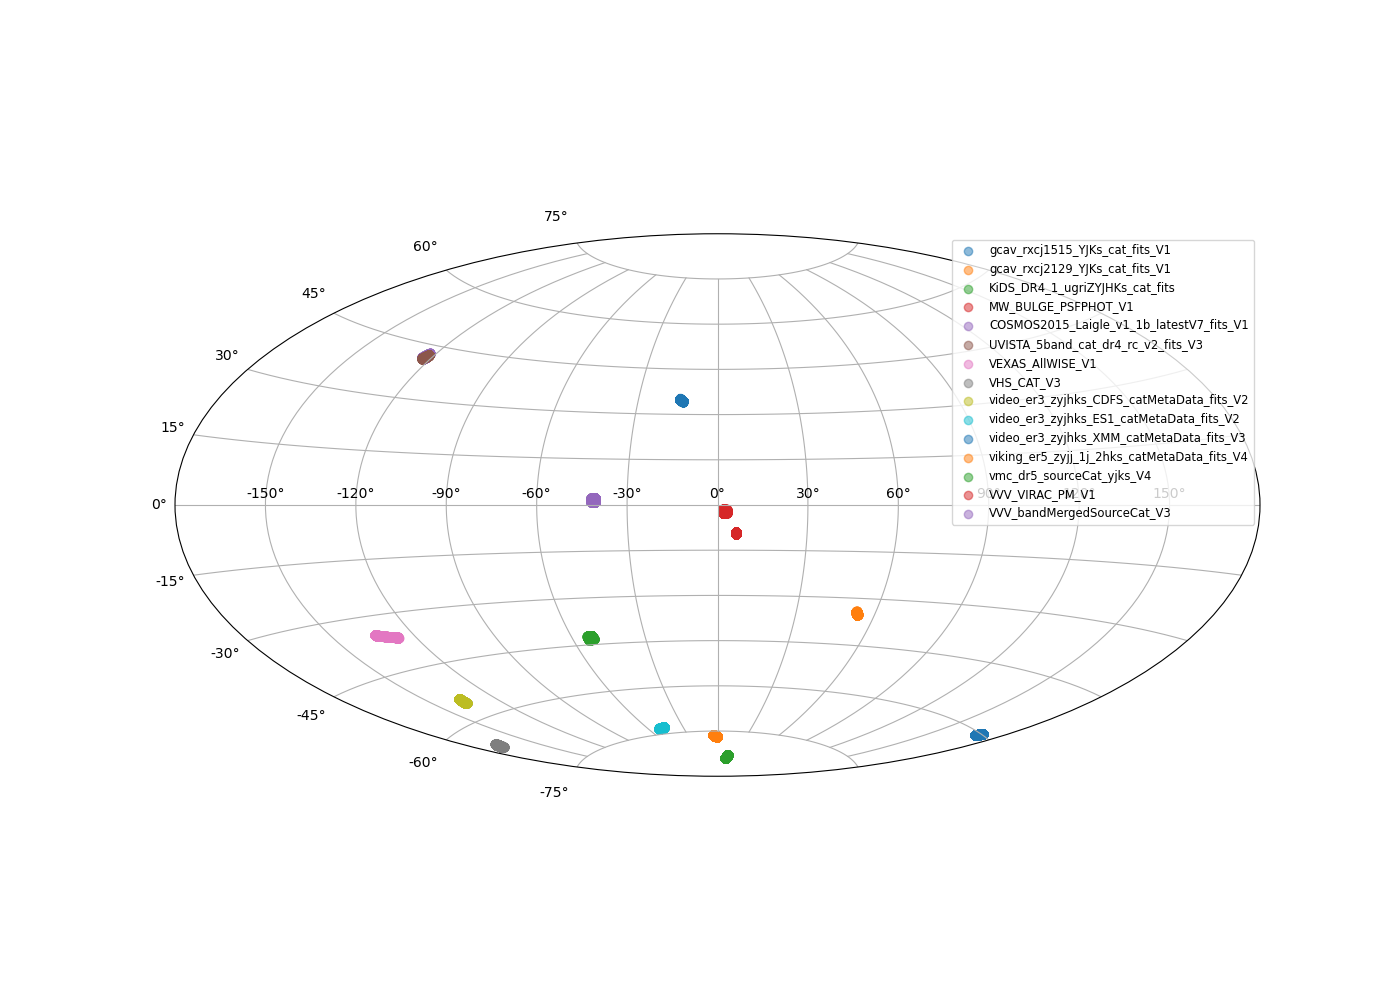

[INFO]    :: The query to gcav_rxcj1515_YJKs_cat_fits_V1 returned 5000 entries (with a limit set to maxrec=5000)
[INFO]    :: The query to gcav_rxcj2129_YJKs_cat_fits_V1 returned 5000 entries (with a limit set to maxrec=5000)
[INFO]    :: The query to KiDS_DR4_1_ugriZYJHKs_cat_fits returned 5000 entries (with a limit set to maxrec=5000)
[INFO]    :: The query to MW_BULGE_PSFPHOT_V1 returned 5000 entries (with a limit set to maxrec=5000)
[INFO]    :: The query to COSMOS2015_Laigle_v1_1b_latestV7_fits_V1 returned 5000 entries (with a limit set to maxrec=5000)
[INFO]    :: The query to UVISTA_5band_cat_dr4_rc_v2_fits_V3 returned 5000 entries (with a limit set to maxrec=5000)
[INFO]    :: The query to VEXAS_AllWISE_V1 returned 5000 entries (with a limit set to maxrec=5000)
[INFO]    :: The query to VHS_CAT_V3 returned 5000 entries (with a limit set to maxrec=5000)
[INFO]    :: The query to video_er3_zyjhks_CDFS_catMetaData_fits_V2 returned 5000 entries (with a limit set to maxrec=5000)
[IN

In [14]:
# for convenience we limit the number of retrieved entries to 5000000
maxrec=5000000
plt.figure(figsize=(14,10))
plt.subplot(111, projection='aitoff')
plt.grid(True)
for idx in range(len(vista_catalogues)):
    table_name =  vista_catalogues['table_name'][idx]
    target_table =  vista_catalogues['target_table'][idx]
    if target_table is '':
        # Getting RA and Dec
        columns = archive_catalogues.columns_info(tables=table_name)
        columns_pos = [columns['column_name'][ (columns['ucd'] == 'pos.eq.ra;meta.main') ][0],
                       columns['column_name'][ (columns['ucd'] == 'pos.eq.dec;meta.main') ][0]]
        positions = archive_catalogues.get_catalogues(tables=table_name, columns=columns_pos, maxrec=maxrec)
        # Converting RA and Dec in SkyCoord object and taking care of the `Degree` entries
        if not isinstance(positions[columns_pos[0]].unit, u.core.Unit):
            positions[columns_pos[0]].unit = u.deg
            positions[columns_pos[1]].unit = u.deg
        sky_positions = SkyCoord(positions[columns_pos[0]].data*positions[columns_pos[0]].unit, 
                                 positions[columns_pos[1]].data*positions[columns_pos[1]].unit).galactic
        plt.scatter(sky_positions.l.wrap_at('180d').radian, sky_positions.b.radian, alpha=0.5,
                    label=table_name)
plt.legend(fontsize='small', loc='upper right')
plt.show()
plt.savefig('vista_catalogues.jpg', format='jpg', bbox_inches='tight')